# Day 1&2: Feed forward Neural Network

## Feed Forward NN for Structured Data

### Sources:
Inspired by https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Description:
You are provided with a data set of almost 100,000 job ads from a job platform. In order to make their services more attractive they want to introduce a new feature which predicts the expected number of views for a new job ad based on the job title and a few other features. This will help their customers to create job titels that attract more views.

Some of our students have already vectorized the job titles. (Word embeddings generated by Google's BERT NLP model have been created and provided. Next week you will learn how to do this yourself!) In addition, you have some metadata and some general features of the job titles (e.g. all letters capitalized, ...).

Since there are several hundreds of features, using a neural network seems to be the most promising approach.

## Exercise 2: Regression
Using the same data set as in exercise 1 we now would like to predict directly the expected number of views within 10 days. This time it is a regression problem, which means, that besides prepering a new target vector, you have to adjust the layers of our NN - especially the output layer.

Furthermore, you have to choose an adequate loss function and set the correct metric for the early stopping condition.

Apply your model on the provided features of the test set. You can upload your predictions on Kaggle and compete with your class mates. :)


### Some advices:
  * Define a MSE loss function
  * Scale your data properly
  * Adjust the output activation function


### Bonus: 

  * Play with Tensorboard for tracking and visualizing the training and performance of your models. https://www.tensorflow.org/tensorboard/get_started 

  * Use Tensorboard for tracking and optimizing hyperparameters. Follow this tutorial: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

  * Try to provoke overfitting and underfitting. Check this tutorial: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

  * Compare your results with some other models that you learnt in the machine learning module




# Code


## Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
# Imports
import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, r2_score 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import tempfile
import os
import yaml
import sys

In [0]:
mpl.rcParams['figure.figsize'] = (20, 12)


## Load data and functions
Connect to Google Drive. Code snippets for this and other frequently required operations can be found in the `Code snippets` tab of Google Colab.

You have to authorizate Google Colab to access your Google Drive.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Set working directory
You need to change this to the directory where you have saved this project.

In [0]:
# You have to set your own location!
project_dir = "/gdrive/My Drive/Propulsion Academy/03_Bootcamps/Data Science/Teaching Material/NN & CNN/dev/week-7-exercises/Day1+2_feed_forward_NN"
%cd {project_dir}

/gdrive/My Drive/Propulsion Academy/03_Bootcamps/Data Science/Teaching Material/NN & CNN/dev/week-7-exercises/Day1+2_feed_forward_NN


### Import custom functions
We import some additional functions that are provided in the `functions` directory. Use the same kind of structure to import your own functions.

In order to be able to load `.py` files from the functions folder we first have to add its location to the `sys.path` variable. 

To be sure that the correct function is loaded we insert its location at the very begining of `sys.path`. https://stackoverflow.com/questions/31291608/effect-of-using-sys-path-insert0-path-and-sys-pathappend-when-loading-modul

In [0]:
# Add the corresponding Google Drive folder to sys.path
sys.path.insert(0, os.path.join(project_dir, 'functions'))

# import functions
import tf_metrics
import evaluate_results
import data_loader
import nn_models

### Load configuration file
All required paths for loading the data and additional parameters on how to pre-process it are saved in a configuration file. We use a YAML file.
YAML as a human friendly data serialization standard. You can see it as a more beautiful version of JSON.

It is compatible with all relevant programming languages.

Have a look at the file which is in the `configuration` directory. Add your own parameters which are required for this project.

In [0]:
config_file_path = "./configuration/config_file.yml"
config = yaml.safe_load(open(config_file_path))
print(yaml.dump(config, indent=2))

features:
  categorical: [month, package_id, industry_name, city]
  numerical: [contract_pct_from, contract_pct_to, title_num_words]
  passthrough: [title_aggressive, title_female, title_percent, title_location, title_diploma,
    title_chief, title_prob_en, title_prob_de, title_prob_fr]
paths: {features_test: ./data/jobs_features_test.csv, features_train: ./data/jobs_features_train.csv,
  target_train: ./data/jobs_10dviews_train.csv}
target:
  bins: [0, 10000, 20000, 50000, 100000, 200000, .inf]



### Load the data set from Google Drive

In [0]:
# load training data
X_train_raw, y_train_raw, X_test_raw = data_loader.load_data(project_dir, config)

### Inspect the loaded dataset

In [0]:
print("Shape of data is ", X_train_raw.shape)
X_train_raw.describe()

Shape of data is  (81388, 785)


,contract_pct_from,contract_pct_to,title_num_words,title_aggressive,title_female,title_percent,title_location,title_diploma,title_chief,title_prob_en,title_prob_de,title_prob_fr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
count,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,...,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000,81388.000000
mean,90.633275,96.474714,4.665258,0.039121,0.521404,0.382046,0.011709,0.040116,0.002064,0.189532,0.680005,0.024746,-0.262695,-0.081360,0.059723,-0.276611,0.351807,0.007587,0.328369,0.139038,-0.160400,-0.341064,-0.050812,-0.291748,0.278809,0.316406,-0.272705,0.344238,-0.072571,-0.161621,-0.092773,0.053772,-0.331787,0.005379,-0.080933,0.365234,0.340576,-0.063049,0.050629,-0.072266,...,-0.003885,-0.293945,0.072388,0.055054,-0.033813,0.152222,-0.246582,0.166382,-0.006775,0.214233,-0.220825,0.422363,-0.042908,0.309570,-0.350098,0.110107,-0.193115,0.065125,-0.257812,-0.136719,0.024734,-0.131714,0.343506,-0.175781,-0.022964,-0.224365,-0.162109,-0.201538,-0.316895,-0.232178,0.430176,-0.403320,0.229614,-0.223511,-0.050659,-0.060547,-0.195557,-0.345459,-0.012093,-0.167358
std,18.179258,12.141145,2.481178,0.193885,0.499545,0.485891,0.107575,0.196234,0.045387,0.370144,0.441872,0.146484,0.293457,0.249023,0.261230,0.258057,0.263672,0.221069,0.359131,0.246094,0.262207,0.220581,0.196045,0.310059,0.218628,0.212036,0.257812,0.329590,0.203003,0.298584,0.281982,0.222168,0.245239,0.238281,0.243652,0.263184,0.256592,0.232666,0.251709,0.306885,...,0.217529,0.258301,0.254150,0.301514,0.218994,0.317383,0.274902,0.208740,0.322266,0.289307,0.275879,0.326904,0.219360,0.261719,0.293213,0.237915,0.220459,0.266602,0.274658,0.255127,0.284912,0.271729,0.310059,0.375732,0.677734,0.252197,0.246704,0.236572,0.288818,0.258789,0.275635,0.318604,0.238892,0.209961,0.310547,0.261475,0.244263,0.215820,0.188843,0.265137
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.454102,-1.500977,-1.343750,-1.681641,-0.941895,-1.046875,-0.886230,-0.867188,-1.428711,-1.497070,-0.862793,-1.574219,-0.854004,-0.590820,-1.564453,-1.136719,-1.098633,-1.077148,-1.237305,-0.916016,-1.345703,-1.133789,-1.242188,-0.740723,-1.365234,-0.985352,-1.442383,-1.048828,...,-1.007812,-1.264648,-0.737793,-1.043945,-1.010742,-1.610352,-1.709961,-0.728027,-1.219727,-0.985840,-1.507812,-0.722168,-1.152344,-1.120117,-1.238281,-1.153320,-1.157227,-1.080078,-1.401367,-1.351562,-1.289062,-1.041016,-1.147461,-1.359375,-6.027344,-1.473633,-1.374023,-1.381836,-1.464844,-1.450195,-0.723633,-1.665039,-0.738281,-1.167969,-1.069336,-1.013672,-1.284180,-1.248047,-0.867188,-1.287109
25%,80.000000,100.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.466309,-0.240479,-0.105774,-0.439941,0.169678,-0.147461,0.065308,-0.018616,-0.330078,-0.481201,-0.180054,-0.520020,0.

,0
count,8.138800e+04
mean,6.470638e+04
std,6.636027e+04
min,0.000000e+00
25%,2.523000e+04
50%,4.655000e+04
75%,8.168000e+04
max,4.880180e+06


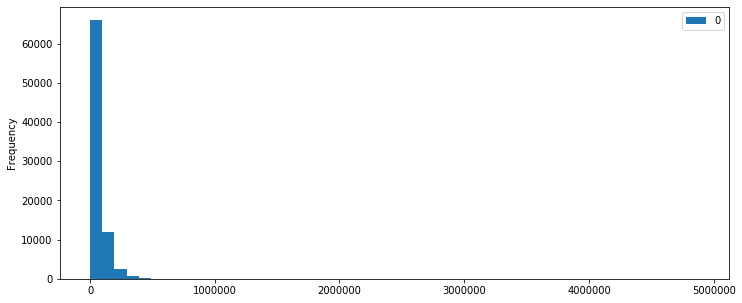

In [0]:
y_train_raw.plot.hist(bins=50, figsize=[12,5])
y_train_raw.describe()

## Preprocessing


### Build a preprocessing pipeline

We use the column transformer from sklearn to apply different transformation on numerical and categorical features. Furthermore, some features don't have to be transformed and are just passed trough.

All required steps for creating a transformer are provided in the `data_loader` file. Have a look at it and follow the individual steps. I hope you remember from the machine learning module how it works. ;)

We manually add a list of strings of all the numbers from 0 to 767. These are the columns which contain a vectorised representation of the job titles. For now you don't need to understand their exact meaning and how they have been created. You are going to learn it next week. Just see them as a condensed numerical representation of the information contained in the job titles. Since these vectors are already normalised, we don't need to scale them.

In [0]:
data_transformer = data_loader.make_data_transformer(
    config['features']['numerical'],
    config['features']['categorical'],
    config['features']['passthrough'] + [str(number) for number in range(0,768)]
    )

### Train-test split

In [0]:
# split data into train and validation set
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_train_raw, 
    y_train_raw, 
    test_size=0.2,
    )

# apply preprocessing
X_train = data_transformer.fit_transform(X_train_)
X_val = data_transformer.transform(X_val_)
X_test = data_transformer.transform(X_test_raw)

# scale target varible
y_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
# y_transformer = MinMaxScaler()

y_train = y_transformer.fit_transform(y_train_)
y_val = y_transformer.transform(y_val_)


In [0]:
print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print()
print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
# print('Test features shape:', X_test.shape)

Training labels shape: (65110, 1)
Validation labels shape: (16278, 1)

Training features shape: (65110, 829)
Validation features shape: (16278, 829)


In [0]:
# Continue on your own!

## Hyperparameter tuning using TensorBoard
Let's try to optimise some hyperparameters. We are following this tutorial:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

Import TensorFlow and the TensorBoard HParams plugin:

In [0]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

# Continue on your own!

### Prepare for submission

In [0]:
y_test_scaled = model.predict(X_test)
y_test = y_transformer.inverse_transform(y_test_scaled)

In [0]:
df_y_test_pred = pd.DataFrame(y_test).reset_index().rename(columns={'index': 'Id', 0: 'ViewCount'})
df_y_test_pred.to_csv('./data/jobs_10dviews_test_prediction.csv', index=None)

In [0]:
df_y_test = pd.read_csv('./data/jobs_10dviews_test.csv', header=None)
df_y_test = df_y_test.reset_index()
df_y_test = df_y_test.rename(columns={'index': 'Id', 0: 'Expected'})
df_y_test.to_csv('./data/jobs_10dviews_test_expected.csv', index=None)